A simple re-implementation of the GP from [Gorda et al](http://arxiv.org/abs/2204.11877).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from scipy.integrate import cumulative_trapezoid
from pqcd.utils import nsat

In [2]:
rng = np.random.default_rng()

At low densities we have a crust model. We'll want to attach our EOS draws to this. We use the BPS EOS from https://arxiv.org/abs/1303.4662.

In [3]:
crust = pd.read_csv('../data/bps_eos.csv')

In [4]:
crust_number_density = crust['n/n0'].values*nsat
crust_pressure = crust['p'].values/1000
crust_energy_density = crust['epsilon'].values/1000

crust_chemical_potential = (
    crust_energy_density+crust_pressure
    )/crust_number_density

crust_speed_of_sound_squared = np.gradient(
    crust_pressure, crust_energy_density
)

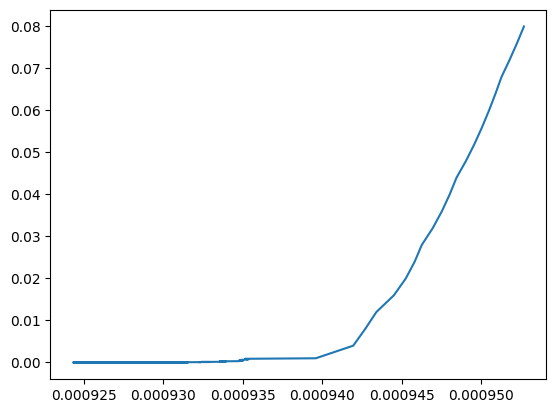

In [5]:
fig, ax = plt.subplots()
ax.plot(crust_chemical_potential/1000, crust_number_density);

We need a mean and kernel for our GP

In [6]:
def phi(cs2):
    return -np.log(1/cs2 - 1)

In [7]:
# I believe they just have a constant for the mean?
def mean(cs2_bar):
    return phi(cs2_bar)

def K(n, nprime, eta, l):
    return eta*np.exp(-(n-nprime)**2/(2*l**2))

Hyperparameters are drawn from normal distributions

In [8]:
l = rng.normal(loc=1*nsat, scale=0.25*nsat)
eta = rng.normal(loc=1.25, scale=0.2)
cs2_bar = rng.normal(loc=0.5, scale=0.25)

We also want to condition the EOS at low densities with some predictions from the literature. We take the average and the difference of the "soft" and "stiff" EOS from [Hebeler et al. (2013)](https://arxiv.org/abs/1303.4662) as the mean and 90% credible interval of the training data used to condition the EOS.

In [9]:
soft_eos = pd.read_csv('../data/soft_eos.csv')

soft_number_density = soft_eos['n/n0'].values
chiEFT_mask = soft_number_density <= 1.1

soft_number_density = soft_number_density[chiEFT_mask]*nsat
soft_pressure = soft_eos['p'].values[chiEFT_mask]/1000
soft_energy_density = soft_eos['epsilon'].values[chiEFT_mask]/1000

soft_chemical_potential = (
    soft_energy_density+soft_pressure
    )/soft_number_density

soft_speed_of_sound_squared = np.gradient(
    soft_pressure, soft_energy_density
)

In [10]:
stiff_eos = pd.read_csv('../data/stiff_eos.csv')

stiff_number_density = stiff_eos['n/n0'].values
chiEFT_mask = stiff_number_density <= 1.1

stiff_number_density = stiff_number_density[chiEFT_mask]*nsat
stiff_pressure = stiff_eos['p'].values[chiEFT_mask]/1000
stiff_energy_density = stiff_eos['epsilon'].values[chiEFT_mask]/1000

stiff_chemical_potential = (
    stiff_energy_density+stiff_pressure
    )/stiff_number_density

stiff_speed_of_sound_squared = np.gradient(
    stiff_pressure, stiff_energy_density
)

In [11]:
soft_phi = phi(soft_speed_of_sound_squared)
stiff_phi = phi(stiff_speed_of_sound_squared)

training_n = soft_number_density
training_phi = np.mean([soft_phi, stiff_phi], axis=0)
psi = (stiff_phi - soft_phi)/(2*1.645)

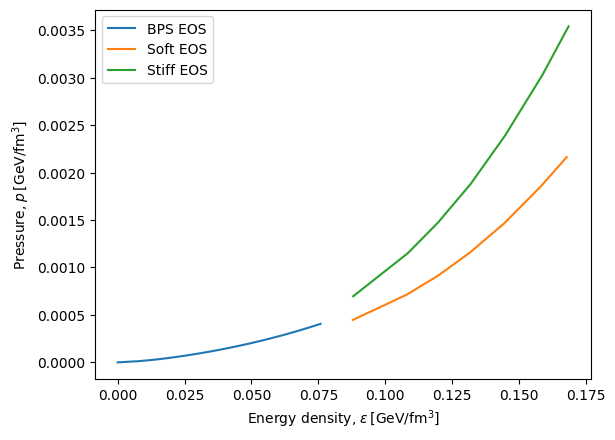

In [12]:
fig, ax = plt.subplots()

ax.plot(crust_energy_density, crust_pressure, label='BPS EOS')
ax.plot(soft_energy_density, soft_pressure, label='Soft EOS')
ax.plot(stiff_energy_density, stiff_pressure, label='Stiff EOS')

ax.legend()

ax.set_xlabel('Energy density, $\epsilon\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Pressure, $p\,[\mathrm{GeV}/\mathrm{fm}^3]$');

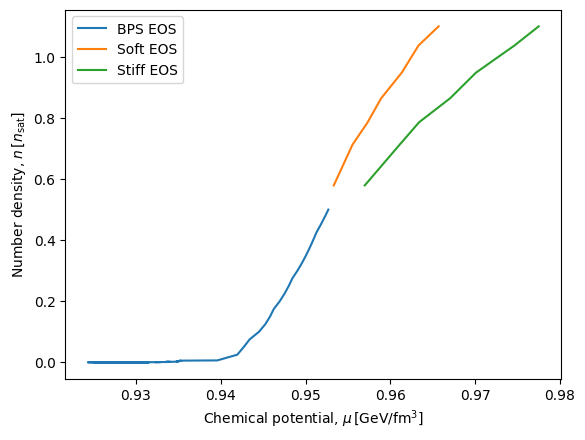

In [13]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density/nsat, label='BPS EOS')
ax.plot(soft_chemical_potential, soft_number_density/nsat, label='Soft EOS')
ax.plot(stiff_chemical_potential, stiff_number_density/nsat, label='Stiff EOS')

ax.legend()

ax.set_xlabel('Chemical potential, $\mu\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Number density, $n\,[n_\mathrm{sat}]$');

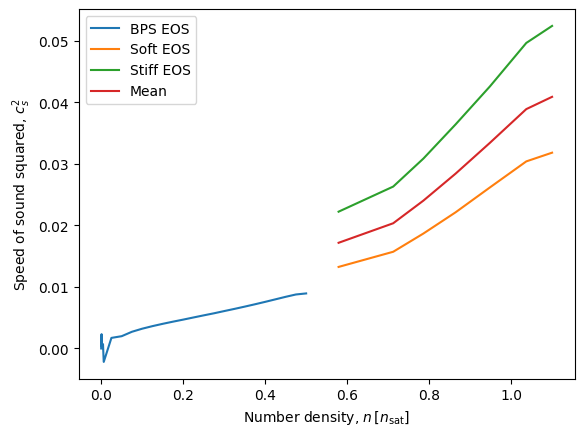

In [14]:
fig, ax = plt.subplots()

ax.plot(crust_number_density/nsat, crust_speed_of_sound_squared, label='BPS EOS')
ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, label='Soft EOS')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, label='Stiff EOS')
ax.plot(soft_number_density/nsat, 1/(np.exp(-training_phi) + 1), label='Mean')

ax.legend()

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

In [15]:
nL = soft_number_density[0]
nH = 10*nsat
n_points = 500

n_array = np.linspace(nL, nH, num=n_points)

In [16]:
training_dim = len(training_n)

In [17]:
n_array_prime = np.append(training_n, n_array)

In [18]:
repeats = 100
phi_draws = []

for _ in range(repeats):

    # Draw hyperparameters
    l = rng.normal(loc=1*nsat, scale=0.25*nsat)
    eta = rng.normal(loc=1.25, scale=0.2)
    cs2_bar = rng.normal(loc=0.5, scale=0.25)

    mu = mean(cs2_bar)

    # Construct the covariance matrix
    Sigma = np.zeros((n_points + training_dim, n_points + training_dim))
    for i, n in enumerate(n_array_prime):
        for j, nprime in enumerate(n_array_prime):
            Sigma[i, j] = K(n, nprime, eta, l)

    # Condition

    sigma_XX = Sigma[training_dim:, training_dim:]
    sigma_YY = Sigma[:training_dim, :training_dim] + psi**2*np.eye(training_dim)

    sigma_XY = Sigma[training_dim:, :training_dim]
    sigma_YX = Sigma[:training_dim, training_dim:]

    sigma_YY_inv = np.linalg.inv(sigma_YY)

    mup = mu + sigma_XY @ sigma_YY_inv @ (training_phi - mu)
    Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

    # Draw phi(n)
    phi_draws.append(rng.multivariate_normal(mup, Sigmap))

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_72202/2845575757.py:2: RuntimeWarning: invalid value encountered in log
  return -np.log(1/cs2 - 1)


In [19]:
phi_draws = np.array(phi_draws)

In [20]:
cs2_draws = 1/(np.exp(-phi_draws) + 1)

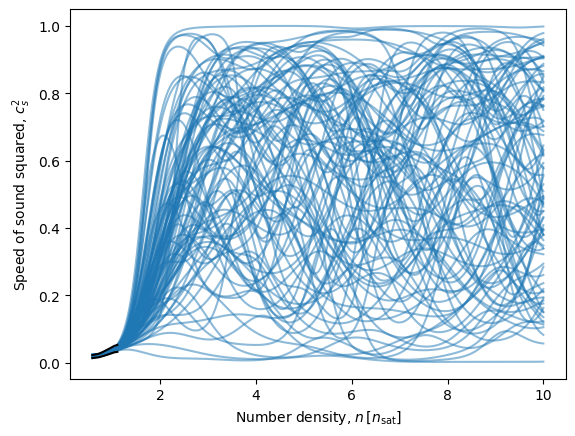

In [21]:
fig, ax = plt.subplots()

for cs2_draw in cs2_draws:
    ax.plot(n_array/nsat, cs2_draw, c='C0', alpha=0.5)

ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, c='k')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, c='k')

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

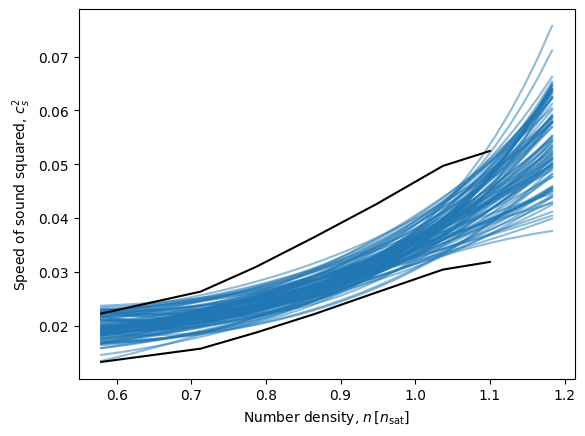

In [22]:
fig, ax = plt.subplots()

plot_mask = n_array < 1.2*nsat

for cs2_draw in cs2_draws:
    ax.plot(n_array[plot_mask]/nsat, cs2_draw[plot_mask], c='C0', alpha=0.5)

ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, c='k')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, c='k')

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

In [ ]:
mu0 = (soft_chemical_potential[0] + stiff_chemical_potential[0])/2

In [24]:
mu_draws = []

for cs2_draw in cs2_draws:
    mu_draws.append(mu0*np.exp(cumulative_trapezoid(y=cs2_draw/n_array, x=n_array, initial=0)))

mu_draws = np.array(mu_draws)

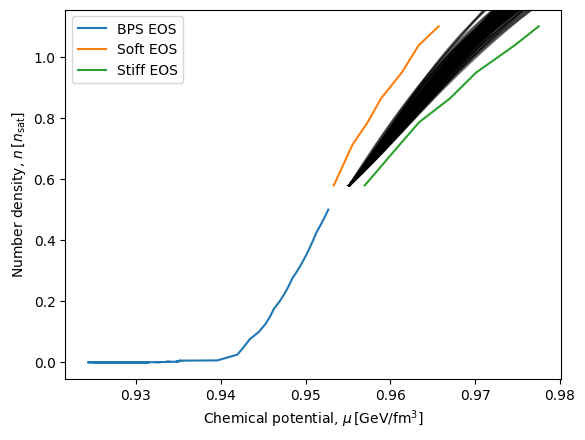

In [25]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density/nsat, label='BPS EOS')
ax.plot(soft_chemical_potential, soft_number_density/nsat, label='Soft EOS')
ax.plot(stiff_chemical_potential, stiff_number_density/nsat, label='Stiff EOS')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for mu_draw in mu_draws:
    ax.plot(mu_draw, n_array/nsat, c='k', alpha=0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend()

ax.set_xlabel('Chemical potential, $\mu\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Number density, $n\,[n_\mathrm{sat}]$');

In [26]:
epsilon0 = (soft_energy_density[0] + stiff_energy_density[0])/2

In [27]:
epsilon_draws = []
for mu_draw in mu_draws:
    epsilon_draws.append(epsilon0 + cumulative_trapezoid(y=mu_draw, x=n_array, initial=0))
epsilon_draws = np.array(epsilon_draws)

In [28]:
p_draws = -epsilon_draws + mu_draws*n_array

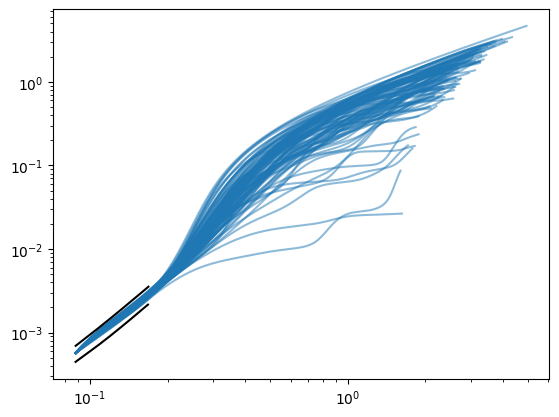

In [29]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for epsilon_draw, p_draw in zip(epsilon_draws, p_draws):
    ax.plot(epsilon_draw, p_draw, c='C0', alpha=0.5)

ax.plot(soft_energy_density, soft_pressure, c='k')
ax.plot(stiff_energy_density, stiff_pressure, c='k');

In [30]:
X_array = np.linspace(0.5, 2, num=50)
muH_array = np.linspace(2.2, 2*2.6, num=50)

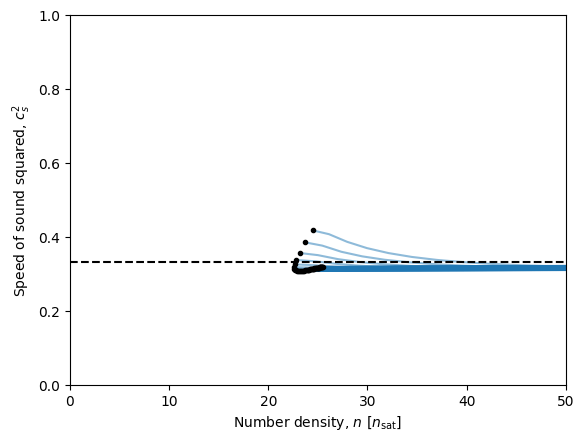

In [31]:
fig, ax = plt.subplots()

for X in X_array:

    pQCDX = pqcd.pQCD(X)

    p_list = []
    n_list = []
    epsilon_list = []

    for muH in muH_array:
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)
        p_list.append(pH)
        n_list.append(nH)
        epsilon_list.append(epsilonH)

    ax.plot(np.array(n_list)/nsat, np.gradient(p_list, epsilon_list), c='C0', alpha=0.5)
    ax.plot(n_list[0]/nsat, np.gradient(p_list, epsilon_list)[0], '.', c='k')

ax.axhline(1/3, c='k', ls='--')

ax.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')
ax.set_ylabel('Speed of sound squared, $c_s^2$')

ax.set_xlim(0,50)
ax.set_ylim(0,1);

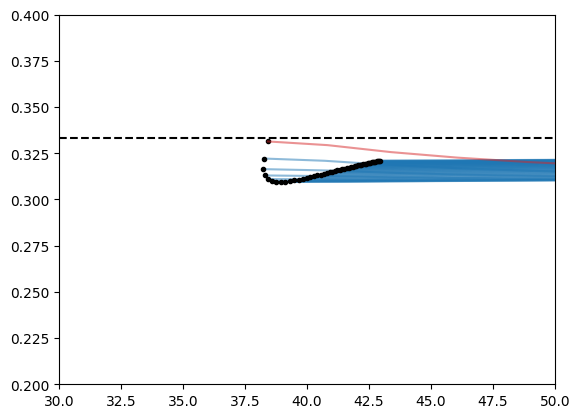

In [32]:
X_array = np.linspace(0.5, 2, num=50)
muH_array = np.linspace(2.6, 2*2.6, num=50)

fig, ax = plt.subplots()

data = {}

for X in X_array:

    if X == 0.5:
        c = 'C3'
        zorder=10
    else:
        c = 'C0'
        zorder=1

    pQCDX = pqcd.pQCD(X)

    p_list = []
    n_list = []
    epsilon_list = []

    for muH in muH_array:
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)
        p_list.append(pH)
        n_list.append(nH)
        epsilon_list.append(epsilonH)

    data[X] = (n_list, np.gradient(p_list, epsilon_list))
    ax.plot(np.array(n_list)/nsat, np.gradient(p_list, epsilon_list), c=c, alpha=0.5, zorder=zorder)
    ax.plot(n_list[0]/nsat, np.gradient(p_list, epsilon_list)[0], '.', c='k')

ax.axhline(1/3, c='k', ls='--')

ax.set_xlim(30,50)
ax.set_ylim(0.2,0.4);

In [33]:
min_n = 50*nsat

for X, (n_list, cs2_list) in data.items():
    if min(n_list) < min_n:
        min_n = min(n_list)

In [34]:
min_n/nsat

38.21930505439354

In [35]:
dense_n_list = np.linspace(min_n, 50*nsat, num=50)

In [36]:
from scipy.interpolate import interp1d

In [37]:
cs2_lists = []

for X, (n_list, cs2_list) in data.items():
    cs2_lists.append(interp1d(n_list, cs2_list, bounds_error=False)(dense_n_list))

In [38]:
cs2_lists = np.array(cs2_lists)

In [39]:
upper_bound = []
lower_bound = []
for entry in cs2_lists.T:
    entry = entry[~np.isnan(entry)]
    upper_bound.append(np.max(entry))
    lower_bound.append(np.min(entry))

(0.2, 0.4)

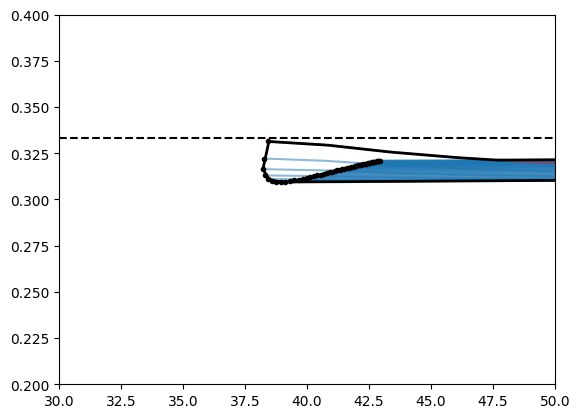

In [40]:
X_array = np.linspace(0.5, 2, num=50)
muH_array = np.linspace(2.6, 2*2.6, num=50)

fig, ax = plt.subplots()

data = {}

for X in X_array:

    if X == 0.5:
        c = 'C3'
        zorder=10
    else:
        c = 'C0'
        zorder=1

    pQCDX = pqcd.pQCD(X)

    p_list = []
    n_list = []
    epsilon_list = []

    for muH in muH_array:
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)
        p_list.append(pH)
        n_list.append(nH)
        epsilon_list.append(epsilonH)

    data[X] = (n_list, np.gradient(p_list, epsilon_list))
    ax.plot(np.array(n_list)/nsat, np.gradient(p_list, epsilon_list), c=c, alpha=0.5, zorder=zorder)
    ax.plot(n_list[0]/nsat, np.gradient(p_list, epsilon_list)[0], '.', c='k')

ax.axhline(1/3, c='k', ls='--')

ax.plot(dense_n_list/nsat, upper_bound, c='k', zorder=11, lw=2)
ax.plot(dense_n_list/nsat, lower_bound, c='k', zorder=11, lw=2)

ax.set_xlim(30,50)
ax.set_ylim(0.2,0.4)

In [41]:
mask = dense_n_list > 40*nsat

lower_phi = phi(np.array(lower_bound)[mask])
upper_phi = phi(np.array(upper_bound)[mask])

training_n = np.concatenate([soft_number_density, dense_n_list[mask]])
training_phi = np.concatenate([np.mean([soft_phi, stiff_phi], axis=0), np.mean([lower_phi, upper_phi], axis=0)])

In [42]:
psi_upper = (upper_phi - lower_phi)/(2*1.645)
psi = np.concatenate([psi, psi_upper])

In [43]:
training_n

array([0.092672  , 0.113984  , 0.125776  , 0.138336  , 0.151728  ,
       0.165936  , 0.176     , 6.42282941, 6.46129699, 6.49976456,
       6.53823214, 6.57669971, 6.61516729, 6.65363486, 6.69210244,
       6.73057001, 6.76903759, 6.80750516, 6.84597274, 6.88444032,
       6.92290789, 6.96137547, 6.99984304, 7.03831062, 7.07677819,
       7.11524577, 7.15371334, 7.19218092, 7.23064849, 7.26911607,
       7.30758364, 7.34605122, 7.38451879, 7.42298637, 7.46145395,
       7.49992152, 7.5383891 , 7.57685667, 7.61532425, 7.65379182,
       7.6922594 , 7.73072697, 7.76919455, 7.80766212, 7.8461297 ,
       7.88459727, 7.92306485, 7.96153242, 8.        ])

In [44]:
nL = soft_number_density[0]
nH = 50*nsat
n_points = 1000

n_array = np.linspace(nL, nH, num=n_points)

In [45]:
training_dim = len(training_n)
n_array_prime = np.append(training_n, n_array)

In [46]:
repeats = 100
phi_draws = []

for _ in range(repeats):

    # Draw hyperparameters
    l = rng.normal(loc=1*nsat, scale=0.25*nsat)
    eta = rng.normal(loc=1.25, scale=0.2)
    cs2_bar = rng.normal(loc=0.5, scale=0.25)

    mu = mean(cs2_bar)

    # Construct the covariance matrix
    Sigma = np.zeros((n_points + training_dim, n_points + training_dim))
    for i, n in enumerate(n_array_prime):
        for j, nprime in enumerate(n_array_prime):
            Sigma[i, j] = K(n, nprime, eta, l)

    # Condition

    sigma_XX = Sigma[training_dim:, training_dim:]
    sigma_YY = Sigma[:training_dim, :training_dim] + psi**2*np.eye(training_dim)

    sigma_XY = Sigma[training_dim:, :training_dim]
    sigma_YX = Sigma[:training_dim, training_dim:]

    sigma_YY_inv = np.linalg.inv(sigma_YY)

    mup = mu + sigma_XY @ sigma_YY_inv @ (training_phi - mu)
    Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

    # Draw phi(n)
    phi_draws.append(rng.multivariate_normal(mup, Sigmap))

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_72202/2845575757.py:2: RuntimeWarning: invalid value encountered in log
  return -np.log(1/cs2 - 1)


In [47]:
phi_draws = np.array(phi_draws)
cs2_draws = 1/(np.exp(-phi_draws) + 1)

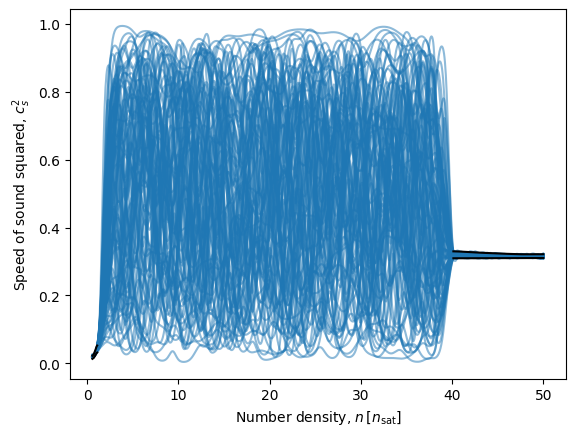

In [48]:
fig, ax = plt.subplots()

for cs2_draw in cs2_draws:
    ax.plot(n_array/nsat, cs2_draw, c='C0', alpha=0.5)

ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, c='k')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, c='k')

ax.plot(dense_n_list[mask]/nsat, np.array(lower_bound)[mask], c='k')
ax.plot(dense_n_list[mask]/nsat, np.array(upper_bound)[mask], c='k')

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');